# Lab 9: Vision Transformer



Hiroto Honda  [homepage](https://hirotomusiker.github.io/)  

<a href="http://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>  

This notebook provides the simple walkthrough of the Vision Transformer.

credits:
- Paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929
- Model Implementation: this notebook loads (and is inspired by) Ross Wightman (@wightmanr)'s amazing module: https://github.com/rwightman/pytorch-image-models/tree/master/timm . For the detailed codes, please refer to the repo.
- The copyright of figures and demo images belongs to Hiroto Honda.



# Preparation

In [1]:
%%capture
!pip install timm

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

# Prepare Model and Data

In [3]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [4]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [5]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

# Simple Inference

In [6]:
# end-to-end inference
output = model(img_tensor)

Inference Result:
church, church_building



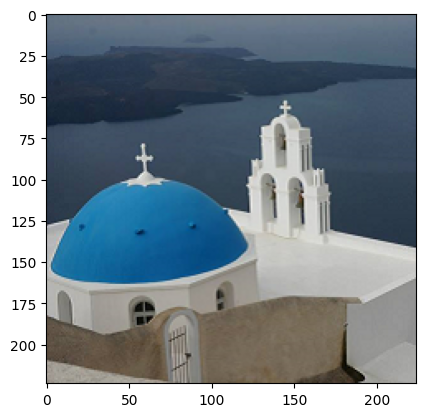

In [7]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Dig into Vision Transformer

Let's look at the details of the Vision Transformer!


<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

Figure 1. Vision Transformer inference pipeline.  
1. Split Image into Patches  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16).
2. Add Position Embeddings  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder.
3. Transformer Encoder  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. Details of the encoder are depicted in Fig. 2.
4. MLP (Classification) Head  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.


# 1. Split Image into Patches

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [8]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape) # 224/14
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


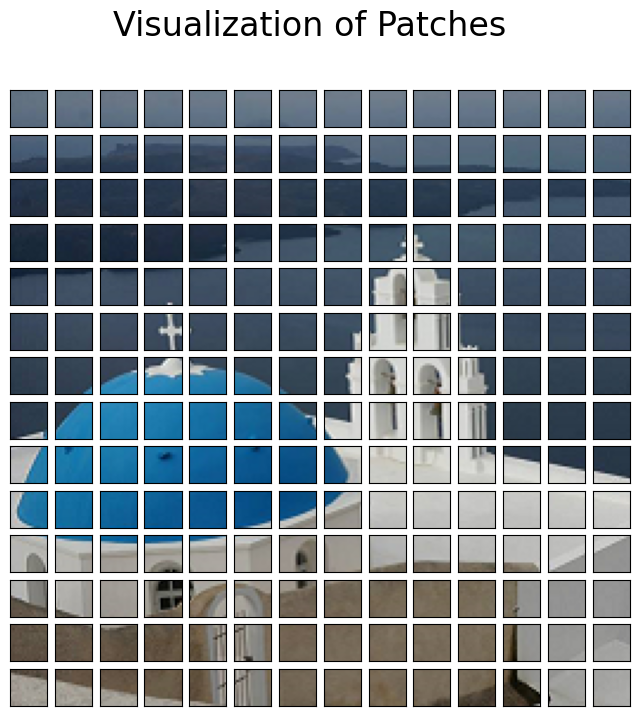

In [9]:
# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d
# with stride=(16, 16) shown above.
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
# fig.add_axes()
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

# 2. Add Position Embeddings
To make patches position-aware, learnable 'position embedding' vectors are added to the patch embedding vectors. The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

### Visualization of position embeddings

In [10]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


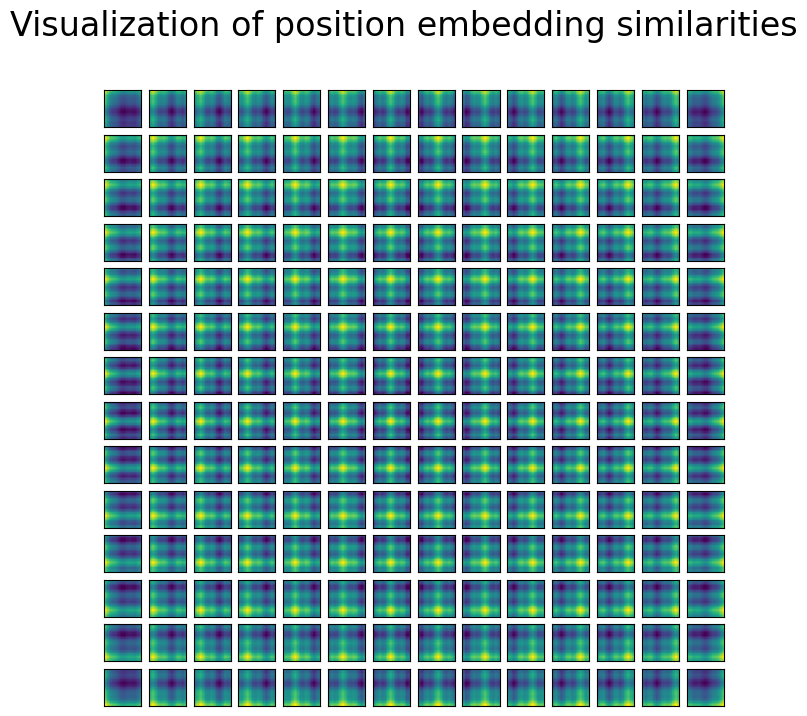

In [11]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### 2a. Why do you think we did not use the patch representation as is and there was a need for position embeddings?

In the context of Vision Transformers (ViTs), position embeddings play a crucial role in preserving the spatial information of the input images. Here are the key reasons why we do not use the patch representation as is and require position embeddings:

Lack of Spatial Information:

When an image is divided into patches, each patch is treated independently. Unlike convolutional neural networks (CNNs), which inherently maintain spatial relationships through their local receptive fields, the ViT processes these patches in a way that loses their original spatial arrangement. Without position embeddings, the model would not have any information about where each patch belongs in the overall image structure.
Transformer Architecture:

Transformers were initially designed for sequential data (like text), where the order of tokens is crucial. In a similar manner, when processing image patches, we need a mechanism to convey the relative or absolute position of these patches. Position embeddings allow the model to understand the arrangement and relationships between the patches, enabling it to learn spatial hierarchies and contextual features.
Enhanced Representation Learning:

Position embeddings allow the transformer to capture the relationships between different parts of the image. By encoding the position information, the model can learn to differentiate between patches that may have similar content but occupy different locations within the image. This enhances the representational power of the transformer and aids in tasks that require an understanding of spatial context, such as image classification or object detection.

### Make Transformer Input
A learnable class token is prepended to the patch embedding vectors as the 0th vector.  
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [12]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Figure 2. Detailed schematic of Transformer Encoder.
- N (=197) embedded vectors are fed to the L (=12) series encoders.
- The vectors are divided into query, key and value after expanded by an fc layer.
- q, k and v are further divided into H (=12) and fed to the parallel attention heads.
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

Implementation Reference:

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)


### Series Transformer Encoders

In [13]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


## How Attention Works

In this part, we are going to see what the actual attention looks like.

In [14]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [15]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [16]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


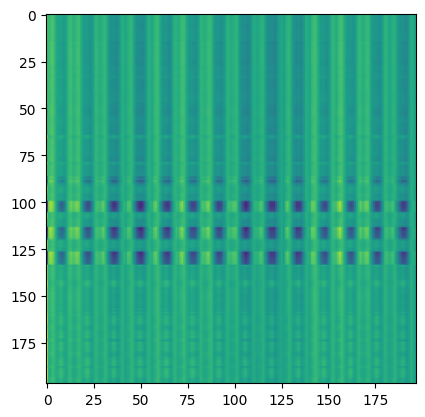

In [17]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

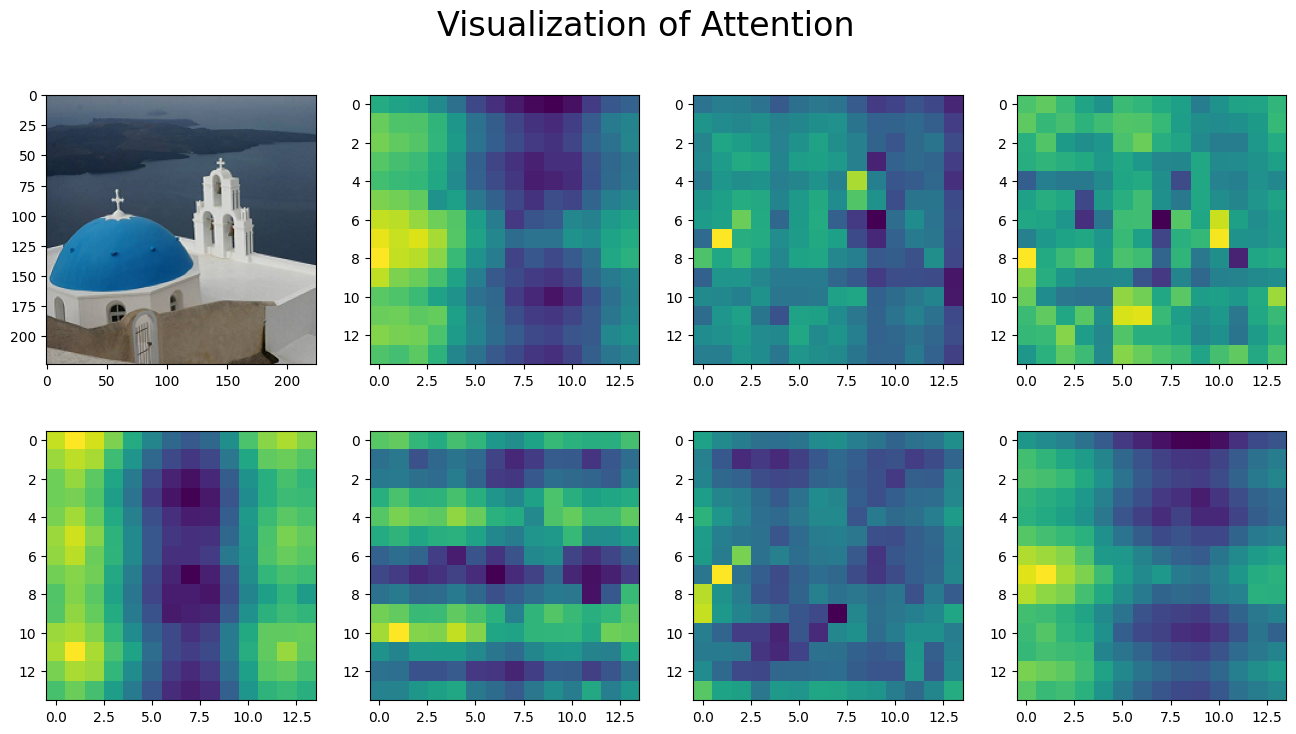

In [18]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
# fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

### 3a. What is the attention block doing?

The attention block in a Vision Transformer (ViT) serves several key functions:

Contextual Weighting:

The attention mechanism allows the model to weigh the importance of different patches in relation to each other. This means that the model can focus on specific areas of the image that are more relevant for a given task, effectively capturing dependencies across distant parts of the image.
Self-Attention Mechanism:

Within the attention block, the self-attention mechanism computes a score for each patch relative to every other patch. This involves creating three vectors for each patch: queries (Q), keys (K), and values (V). The attention scores are calculated by taking the dot product of the queries and keys, followed by a softmax function to obtain a probability distribution. The resulting scores are then used to weight the values, which are combined to produce a new representation for each patch.
Global Context:

By using self-attention, the model can integrate information from the entire image, rather than relying solely on local features. This enables the model to capture global context and relationships within the data, which is crucial for understanding complex visual patterns.
Dimensionality Reduction:

The attention mechanism effectively reduces the dimensionality of the data by focusing on relevant information and filtering out noise, which can enhance the learning process.

### 3b. What does the color map indicate?

The color map typically represents the attention scores computed during the self-attention process:

Attention Weights:

The color intensity (or color variation) in the map indicates how much attention is given to each patch when processing a specific patch. Brighter or warmer colors may indicate higher attention weights, meaning that the model places greater importance on those patches when forming the representation of the target patch.
Inter-Patch Relationships:

The color map can visually demonstrate how different patches influence each other. For example, if a particular patch in the image has a high attention score towards another patch, this may suggest a strong relationship between the two areas, such as in the case of an object and its context or background.
Understanding Model Behavior:

Analyzing the color map can help interpret the model’s decision-making process, revealing which parts of the image are deemed important for making predictions. This can provide insights into how the model understands and processes visual information, aiding in model evaluation and debugging.

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 497, label name = church, church_building



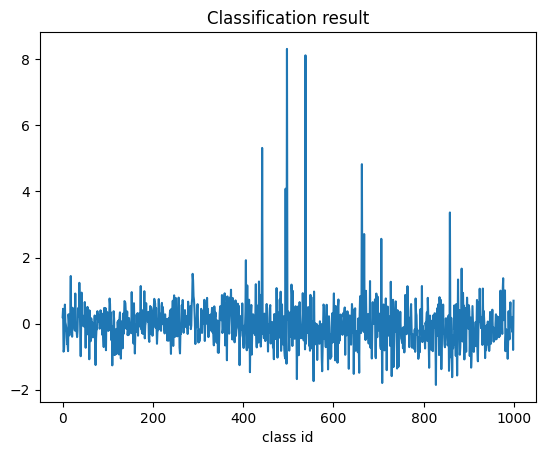

In [19]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

### 4a. What do you understand by the classification result?

The classification result plot provides a visualization of the model's performance across different class IDs, revealing several key insights:

Class Distinction: The plot shows varying confidence scores for different classes, with some classes having significantly higher scores than others, indicating they are easier for the model to classify.

Misclassification Areas: Classes with low or fluctuating scores may suggest difficulty in distinguishing those classes, leading to higher rates of misclassification.

Model Confidence: High peaks in scores indicate the model's confidence in certain classes, while low scores across many classes could imply potential issues with class imbalance or insufficient feature representation.

Overall Model Evaluation: The distribution of scores reflects the overall effectiveness of the model. Identifying classes that consistently score low can guide further training or architectural adjustments to improve classification accuracy.